In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:6]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [4]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [9]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [10]:
prediction_result_cv = []
prediction_result_ind = []

In [11]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2')

In [12]:
out = os.getcwd() + '\\'

In [13]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=300, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0     


Epoch 00025: val_loss did not improve from 0.52218
Epoch 26/300
8/8 - 0s - loss: 0.5087 - accuracy: 0.7588 - val_loss: 0.5300 - val_accuracy: 0.7333

Epoch 00026: val_loss did not improve from 0.52218
Epoch 27/300
8/8 - 0s - loss: 0.4993 - accuracy: 0.7509 - val_loss: 0.5297 - val_accuracy: 0.7289

Epoch 00027: val_loss did not improve from 0.52218
Epoch 28/300
8/8 - 0s - loss: 0.4908 - accuracy: 0.7563 - val_loss: 0.5245 - val_accuracy: 0.7467

Epoch 00028: val_loss did not improve from 0.52218
Epoch 29/300
8/8 - 0s - loss: 0.5006 - accuracy: 0.7558 - val_loss: 0.5206 - val_accuracy: 0.7733

Epoch 00029: val_loss improved from 0.52218 to 0.52061, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_0.h5
Epoch 30/300
8/8 - 0s - loss: 0.4924 - accuracy: 0.7543 - val_loss: 0.5357 - val_accuracy: 0.7200

Epoch 00030: val_loss did not improve from 0.52061
Epoch 31/300
8/8 - 0s - loss: 0.4895 - accuracy: 0.7523 - val_loss:


Epoch 00073: val_loss did not improve from 0.50410
Epoch 74/300
8/8 - 0s - loss: 0.4149 - accuracy: 0.8047 - val_loss: 0.5075 - val_accuracy: 0.7644

Epoch 00074: val_loss did not improve from 0.50410
Epoch 75/300
8/8 - 0s - loss: 0.3989 - accuracy: 0.8240 - val_loss: 0.5164 - val_accuracy: 0.7600

Epoch 00075: val_loss did not improve from 0.50410
Epoch 76/300
8/8 - 0s - loss: 0.3931 - accuracy: 0.8181 - val_loss: 0.5620 - val_accuracy: 0.7289

Epoch 00076: val_loss did not improve from 0.50410
Epoch 77/300
8/8 - 0s - loss: 0.3879 - accuracy: 0.8230 - val_loss: 0.5113 - val_accuracy: 0.7378

Epoch 00077: val_loss did not improve from 0.50410
Epoch 78/300
8/8 - 0s - loss: 0.4004 - accuracy: 0.8107 - val_loss: 0.5181 - val_accuracy: 0.7422

Epoch 00078: val_loss did not improve from 0.50410
Epoch 79/300
8/8 - 0s - loss: 0.3879 - accuracy: 0.8216 - val_loss: 0.5130 - val_accuracy: 0.7467

Epoch 00079: val_loss did not improve from 0.50410
Epoch 80/300
8/8 - 0s - loss: 0.3900 - accuracy:

8/8 - 1s - loss: 0.6604 - accuracy: 0.6164 - val_loss: 0.6213 - val_accuracy: 0.7511

Epoch 00001: val_loss improved from inf to 0.62128, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.6195 - accuracy: 0.6629 - val_loss: 0.5919 - val_accuracy: 0.7511

Epoch 00002: val_loss improved from 0.62128 to 0.59191, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_1.h5
Epoch 3/300
8/8 - 0s - loss: 0.5954 - accuracy: 0.6891 - val_loss: 0.5730 - val_accuracy: 0.7244

Epoch 00003: val_loss improved from 0.59191 to 0.57302, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_1.h5
Epoch 4/300
8/8 - 0s - loss: 0.5885 - accuracy: 0.6782 - val_loss: 0.5652 - val_accuracy: 0.7244

Epoch 00004: val_loss improved from 0.57302 to 0.56518, saving model to D:\Pyc


Epoch 00038: val_loss did not improve from 0.50845
Epoch 39/300
8/8 - 0s - loss: 0.4802 - accuracy: 0.7637 - val_loss: 0.5177 - val_accuracy: 0.7289

Epoch 00039: val_loss did not improve from 0.50845
Epoch 40/300
8/8 - 0s - loss: 0.4753 - accuracy: 0.7746 - val_loss: 0.5180 - val_accuracy: 0.7467

Epoch 00040: val_loss did not improve from 0.50845
Epoch 41/300
8/8 - 0s - loss: 0.4689 - accuracy: 0.7721 - val_loss: 0.5067 - val_accuracy: 0.7733

Epoch 00041: val_loss improved from 0.50845 to 0.50673, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_1.h5
Epoch 42/300
8/8 - 0s - loss: 0.4850 - accuracy: 0.7553 - val_loss: 0.5377 - val_accuracy: 0.6756

Epoch 00042: val_loss did not improve from 0.50673
Epoch 43/300
8/8 - 0s - loss: 0.4734 - accuracy: 0.7761 - val_loss: 0.5388 - val_accuracy: 0.6889

Epoch 00043: val_loss did not improve from 0.50673
Epoch 44/300
8/8 - 0s - loss: 0.4602 - accuracy: 0.7716 - val_loss:


Epoch 00090: val_loss did not improve from 0.50260
Epoch 91/300
8/8 - 0s - loss: 0.3506 - accuracy: 0.8463 - val_loss: 0.5091 - val_accuracy: 0.7556

Epoch 00091: val_loss did not improve from 0.50260
Epoch 92/300
8/8 - 0s - loss: 0.3373 - accuracy: 0.8571 - val_loss: 0.5236 - val_accuracy: 0.7244

Epoch 00092: val_loss did not improve from 0.50260
Epoch 93/300
8/8 - 0s - loss: 0.3508 - accuracy: 0.8443 - val_loss: 0.5287 - val_accuracy: 0.7422

Epoch 00093: val_loss did not improve from 0.50260
Epoch 94/300
8/8 - 0s - loss: 0.3958 - accuracy: 0.8186 - val_loss: 0.5217 - val_accuracy: 0.7333

Epoch 00094: val_loss did not improve from 0.50260
Epoch 95/300
8/8 - 0s - loss: 0.3535 - accuracy: 0.8344 - val_loss: 0.6166 - val_accuracy: 0.6444

Epoch 00095: val_loss did not improve from 0.50260
Epoch 96/300
8/8 - 0s - loss: 0.3848 - accuracy: 0.8270 - val_loss: 0.5098 - val_accuracy: 0.7644

Epoch 00096: val_loss did not improve from 0.50260
Epoch 97/300
8/8 - 0s - loss: 0.3625 - accuracy:

8/8 - 0s - loss: 0.5785 - accuracy: 0.6925 - val_loss: 0.5676 - val_accuracy: 0.7022

Epoch 00006: val_loss did not improve from 0.56499
Epoch 7/300
8/8 - 0s - loss: 0.5576 - accuracy: 0.7034 - val_loss: 0.5657 - val_accuracy: 0.7289

Epoch 00007: val_loss did not improve from 0.56499
Epoch 8/300
8/8 - 0s - loss: 0.5629 - accuracy: 0.7074 - val_loss: 0.5548 - val_accuracy: 0.7244

Epoch 00008: val_loss improved from 0.56499 to 0.55481, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_2.h5
Epoch 9/300
8/8 - 0s - loss: 0.5658 - accuracy: 0.6985 - val_loss: 0.5559 - val_accuracy: 0.7378

Epoch 00009: val_loss did not improve from 0.55481
Epoch 10/300
8/8 - 0s - loss: 0.5506 - accuracy: 0.7014 - val_loss: 0.5496 - val_accuracy: 0.7289

Epoch 00010: val_loss improved from 0.55481 to 0.54959, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_2.h5
Epoc


Epoch 00048: val_loss did not improve from 0.51525
Epoch 49/300
8/8 - 0s - loss: 0.4322 - accuracy: 0.7988 - val_loss: 0.5379 - val_accuracy: 0.7244

Epoch 00049: val_loss did not improve from 0.51525
Epoch 50/300
8/8 - 0s - loss: 0.4479 - accuracy: 0.7785 - val_loss: 0.5315 - val_accuracy: 0.7467

Epoch 00050: val_loss did not improve from 0.51525
Epoch 51/300
8/8 - 0s - loss: 0.4626 - accuracy: 0.7721 - val_loss: 0.5336 - val_accuracy: 0.7244

Epoch 00051: val_loss did not improve from 0.51525
Epoch 52/300
8/8 - 0s - loss: 0.4418 - accuracy: 0.7968 - val_loss: 0.5241 - val_accuracy: 0.7289

Epoch 00052: val_loss did not improve from 0.51525
Epoch 53/300
8/8 - 0s - loss: 0.4495 - accuracy: 0.7870 - val_loss: 0.5239 - val_accuracy: 0.7378

Epoch 00053: val_loss did not improve from 0.51525
Epoch 54/300
8/8 - 0s - loss: 0.4330 - accuracy: 0.8008 - val_loss: 0.5362 - val_accuracy: 0.7244

Epoch 00054: val_loss did not improve from 0.51525
Epoch 55/300
8/8 - 0s - loss: 0.4260 - accuracy:


Epoch 00102: val_loss did not improve from 0.51167
Epoch 103/300
8/8 - 0s - loss: 0.3621 - accuracy: 0.8384 - val_loss: 0.6279 - val_accuracy: 0.6311

Epoch 00103: val_loss did not improve from 0.51167
Epoch 104/300
8/8 - 0s - loss: 0.3615 - accuracy: 0.8379 - val_loss: 0.5612 - val_accuracy: 0.7244

Epoch 00104: val_loss did not improve from 0.51167
Epoch 105/300
8/8 - 0s - loss: 0.3449 - accuracy: 0.8502 - val_loss: 0.5412 - val_accuracy: 0.7156

Epoch 00105: val_loss did not improve from 0.51167
Epoch 106/300
8/8 - 0s - loss: 0.3340 - accuracy: 0.8527 - val_loss: 0.5310 - val_accuracy: 0.7289

Epoch 00106: val_loss did not improve from 0.51167
Epoch 107/300
8/8 - 0s - loss: 0.3189 - accuracy: 0.8611 - val_loss: 0.5378 - val_accuracy: 0.7200

Epoch 00107: val_loss did not improve from 0.51167
Epoch 108/300
8/8 - 0s - loss: 0.3319 - accuracy: 0.8606 - val_loss: 0.5452 - val_accuracy: 0.7067

Epoch 00108: val_loss did not improve from 0.51167
Epoch 109/300
8/8 - 0s - loss: 0.3270 - ac


Epoch 00012: val_loss improved from 0.58752 to 0.58613, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_3.h5
Epoch 13/300
8/8 - 0s - loss: 0.5528 - accuracy: 0.7143 - val_loss: 0.5830 - val_accuracy: 0.7111

Epoch 00013: val_loss improved from 0.58613 to 0.58305, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_3.h5
Epoch 14/300
8/8 - 0s - loss: 0.5338 - accuracy: 0.7261 - val_loss: 0.5915 - val_accuracy: 0.6756

Epoch 00014: val_loss did not improve from 0.58305
Epoch 15/300
8/8 - 0s - loss: 0.5436 - accuracy: 0.7237 - val_loss: 0.5841 - val_accuracy: 0.7111

Epoch 00015: val_loss did not improve from 0.58305
Epoch 16/300
8/8 - 0s - loss: 0.5301 - accuracy: 0.7207 - val_loss: 0.5833 - val_accuracy: 0.7067

Epoch 00016: val_loss did not improve from 0.58305
Epoch 17/300
8/8 - 0s - loss: 0.5289 - accuracy: 0.7291 - val_loss: 0.5784 - val_accur


Epoch 00057: val_loss improved from 0.56060 to 0.55333, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_3.h5
Epoch 58/300
8/8 - 0s - loss: 0.4260 - accuracy: 0.8023 - val_loss: 0.5828 - val_accuracy: 0.7200

Epoch 00058: val_loss did not improve from 0.55333
Epoch 59/300
8/8 - 0s - loss: 0.4482 - accuracy: 0.7850 - val_loss: 0.5597 - val_accuracy: 0.6978

Epoch 00059: val_loss did not improve from 0.55333
Epoch 60/300
8/8 - 0s - loss: 0.4216 - accuracy: 0.8117 - val_loss: 0.5564 - val_accuracy: 0.7067

Epoch 00060: val_loss did not improve from 0.55333
Epoch 61/300
8/8 - 0s - loss: 0.4266 - accuracy: 0.8082 - val_loss: 0.5593 - val_accuracy: 0.7156

Epoch 00061: val_loss did not improve from 0.55333
Epoch 62/300
8/8 - 0s - loss: 0.4176 - accuracy: 0.8033 - val_loss: 0.5575 - val_accuracy: 0.7111

Epoch 00062: val_loss did not improve from 0.55333
Epoch 63/300
8/8 - 0s - loss: 0.4054 - accuracy: 0.8112 - val_loss:

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 5, 128)            199680    
_________________________________________________________________
dense_8 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 208,001
Trainable params: 155,905
Non-trainable params: 52,096
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6570 - accuracy: 0.6011 - val_loss: 0.6259 - val_accuracy: 0.7156

Epoch 00001


Epoch 00032: val_loss improved from 0.53010 to 0.52969, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_4.h5
Epoch 33/300
8/8 - 0s - loss: 0.4838 - accuracy: 0.7632 - val_loss: 0.5235 - val_accuracy: 0.7244

Epoch 00033: val_loss improved from 0.52969 to 0.52345, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_4.h5
Epoch 34/300
8/8 - 0s - loss: 0.4906 - accuracy: 0.7598 - val_loss: 0.5288 - val_accuracy: 0.7422

Epoch 00034: val_loss did not improve from 0.52345
Epoch 35/300
8/8 - 0s - loss: 0.4778 - accuracy: 0.7622 - val_loss: 0.5302 - val_accuracy: 0.7333

Epoch 00035: val_loss did not improve from 0.52345
Epoch 36/300
8/8 - 0s - loss: 0.4826 - accuracy: 0.7558 - val_loss: 0.5365 - val_accuracy: 0.7067

Epoch 00036: val_loss did not improve from 0.52345
Epoch 37/300
8/8 - 0s - loss: 0.4867 - accuracy: 0.7716 - val_loss: 0.5283 - val_accur


Epoch 00080: val_loss did not improve from 0.50856
Epoch 81/300
8/8 - 0s - loss: 0.3945 - accuracy: 0.8240 - val_loss: 0.5445 - val_accuracy: 0.7111

Epoch 00081: val_loss did not improve from 0.50856
Epoch 82/300
8/8 - 0s - loss: 0.4058 - accuracy: 0.8136 - val_loss: 0.5198 - val_accuracy: 0.7467

Epoch 00082: val_loss did not improve from 0.50856
Epoch 83/300
8/8 - 0s - loss: 0.3672 - accuracy: 0.8393 - val_loss: 0.5249 - val_accuracy: 0.7289

Epoch 00083: val_loss did not improve from 0.50856
Epoch 84/300
8/8 - 0s - loss: 0.4008 - accuracy: 0.8107 - val_loss: 0.5145 - val_accuracy: 0.7600

Epoch 00084: val_loss did not improve from 0.50856
Epoch 85/300
8/8 - 0s - loss: 0.3650 - accuracy: 0.8359 - val_loss: 0.5113 - val_accuracy: 0.7467

Epoch 00085: val_loss did not improve from 0.50856
Epoch 86/300
8/8 - 0s - loss: 0.3624 - accuracy: 0.8329 - val_loss: 0.5565 - val_accuracy: 0.7289

Epoch 00086: val_loss did not improve from 0.50856
Epoch 87/300
8/8 - 0s - loss: 0.3928 - accuracy:

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 5, 128)            199680    
_________________________________________________________________
dense_10 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_5 ( (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 155,905
Non-trainable params: 52,096
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6650 - accuracy: 0.5986 - val_loss: 0.6254 - val_accuracy: 0.7289

Epoch 00001


Epoch 00033: val_loss did not improve from 0.52005
Epoch 34/300
8/8 - 0s - loss: 0.4846 - accuracy: 0.7657 - val_loss: 0.5152 - val_accuracy: 0.7556

Epoch 00034: val_loss improved from 0.52005 to 0.51522, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_5.h5
Epoch 35/300
8/8 - 0s - loss: 0.4847 - accuracy: 0.7632 - val_loss: 0.5266 - val_accuracy: 0.7244

Epoch 00035: val_loss did not improve from 0.51522
Epoch 36/300
8/8 - 0s - loss: 0.4752 - accuracy: 0.7608 - val_loss: 0.5318 - val_accuracy: 0.7244

Epoch 00036: val_loss did not improve from 0.51522
Epoch 37/300
8/8 - 0s - loss: 0.4864 - accuracy: 0.7578 - val_loss: 0.5209 - val_accuracy: 0.7422

Epoch 00037: val_loss did not improve from 0.51522
Epoch 38/300
8/8 - 0s - loss: 0.4702 - accuracy: 0.7692 - val_loss: 0.5152 - val_accuracy: 0.7467

Epoch 00038: val_loss improved from 0.51522 to 0.51521, saving model to D:\PycharmProjects\pythonProject\Papernew_data


Epoch 00080: val_loss did not improve from 0.50698
Epoch 81/300
8/8 - 0s - loss: 0.4184 - accuracy: 0.8018 - val_loss: 0.5153 - val_accuracy: 0.7244

Epoch 00081: val_loss did not improve from 0.50698
Epoch 82/300
8/8 - 0s - loss: 0.3791 - accuracy: 0.8295 - val_loss: 0.5373 - val_accuracy: 0.7111

Epoch 00082: val_loss did not improve from 0.50698
Epoch 83/300
8/8 - 0s - loss: 0.3708 - accuracy: 0.8285 - val_loss: 0.5237 - val_accuracy: 0.7333

Epoch 00083: val_loss did not improve from 0.50698
Epoch 84/300
8/8 - 0s - loss: 0.3989 - accuracy: 0.8112 - val_loss: 0.5201 - val_accuracy: 0.7422

Epoch 00084: val_loss did not improve from 0.50698
Epoch 85/300
8/8 - 0s - loss: 0.3646 - accuracy: 0.8339 - val_loss: 0.5228 - val_accuracy: 0.7378

Epoch 00085: val_loss did not improve from 0.50698
Epoch 86/300
8/8 - 0s - loss: 0.3930 - accuracy: 0.8295 - val_loss: 0.5262 - val_accuracy: 0.7378

Epoch 00086: val_loss did not improve from 0.50698
Epoch 87/300
8/8 - 0s - loss: 0.3722 - accuracy:

_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 5, 128)            199680    
_________________________________________________________________
dense_12 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_6 ( (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 155,905
Non-trainable params: 52,096
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6591 - accur


Epoch 00033: val_loss improved from 0.53797 to 0.53525, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_6.h5
Epoch 34/300
8/8 - 0s - loss: 0.4923 - accuracy: 0.7533 - val_loss: 0.5385 - val_accuracy: 0.7111

Epoch 00034: val_loss did not improve from 0.53525
Epoch 35/300
8/8 - 0s - loss: 0.4869 - accuracy: 0.7677 - val_loss: 0.5349 - val_accuracy: 0.7244

Epoch 00035: val_loss improved from 0.53525 to 0.53493, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_6.h5
Epoch 36/300
8/8 - 0s - loss: 0.4882 - accuracy: 0.7578 - val_loss: 0.5353 - val_accuracy: 0.7156

Epoch 00036: val_loss did not improve from 0.53493
Epoch 37/300
8/8 - 0s - loss: 0.4715 - accuracy: 0.7716 - val_loss: 0.5348 - val_accuracy: 0.7289

Epoch 00037: val_loss improved from 0.53493 to 0.53476, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\tar


Epoch 00083: val_loss did not improve from 0.52495
Epoch 84/300
8/8 - 0s - loss: 0.3729 - accuracy: 0.8339 - val_loss: 0.5381 - val_accuracy: 0.7244

Epoch 00084: val_loss did not improve from 0.52495
Epoch 85/300
8/8 - 0s - loss: 0.3913 - accuracy: 0.8176 - val_loss: 0.5582 - val_accuracy: 0.6933

Epoch 00085: val_loss did not improve from 0.52495
Epoch 86/300
8/8 - 0s - loss: 0.3847 - accuracy: 0.8364 - val_loss: 0.5356 - val_accuracy: 0.7333

Epoch 00086: val_loss did not improve from 0.52495
Epoch 87/300
8/8 - 0s - loss: 0.3734 - accuracy: 0.8319 - val_loss: 0.5526 - val_accuracy: 0.6889

Epoch 00087: val_loss did not improve from 0.52495
Epoch 88/300
8/8 - 0s - loss: 0.3729 - accuracy: 0.8300 - val_loss: 0.5351 - val_accuracy: 0.7244

Epoch 00088: val_loss did not improve from 0.52495
Epoch 89/300
8/8 - 0s - loss: 0.3642 - accuracy: 0.8458 - val_loss: 0.6183 - val_accuracy: 0.6889

Epoch 00089: val_loss did not improve from 0.52495
Epoch 90/300
8/8 - 0s - loss: 0.3789 - accuracy:


Epoch 00012: val_loss improved from 0.58195 to 0.57789, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_7.h5
Epoch 13/300
8/8 - 0s - loss: 0.5445 - accuracy: 0.7113 - val_loss: 0.5746 - val_accuracy: 0.7022

Epoch 00013: val_loss improved from 0.57789 to 0.57461, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_7.h5
Epoch 14/300
8/8 - 0s - loss: 0.5372 - accuracy: 0.7257 - val_loss: 0.5772 - val_accuracy: 0.6933

Epoch 00014: val_loss did not improve from 0.57461
Epoch 15/300
8/8 - 0s - loss: 0.5322 - accuracy: 0.7252 - val_loss: 0.5768 - val_accuracy: 0.6667

Epoch 00015: val_loss did not improve from 0.57461
Epoch 16/300
8/8 - 0s - loss: 0.5363 - accuracy: 0.7271 - val_loss: 0.5733 - val_accuracy: 0.7022

Epoch 00016: val_loss improved from 0.57461 to 0.57334, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\tar


Epoch 00057: val_loss did not improve from 0.55819
Epoch 58/300
8/8 - 0s - loss: 0.4256 - accuracy: 0.7968 - val_loss: 0.5617 - val_accuracy: 0.7111

Epoch 00058: val_loss did not improve from 0.55819
Epoch 59/300
8/8 - 0s - loss: 0.4263 - accuracy: 0.8033 - val_loss: 0.5636 - val_accuracy: 0.7200

Epoch 00059: val_loss did not improve from 0.55819
Epoch 60/300
8/8 - 0s - loss: 0.4180 - accuracy: 0.8003 - val_loss: 0.5609 - val_accuracy: 0.7111

Epoch 00060: val_loss did not improve from 0.55819
Epoch 61/300
8/8 - 0s - loss: 0.4410 - accuracy: 0.7761 - val_loss: 0.5624 - val_accuracy: 0.7200

Epoch 00061: val_loss did not improve from 0.55819
Epoch 62/300
8/8 - 0s - loss: 0.4290 - accuracy: 0.7958 - val_loss: 0.5753 - val_accuracy: 0.6889

Epoch 00062: val_loss did not improve from 0.55819
Epoch 63/300
8/8 - 0s - loss: 0.4172 - accuracy: 0.8092 - val_loss: 0.5628 - val_accuracy: 0.7156

Epoch 00063: val_loss did not improve from 0.55819
Epoch 64/300
8/8 - 0s - loss: 0.4113 - accuracy:


Epoch 00110: val_loss did not improve from 0.55675
Epoch 111/300
8/8 - 0s - loss: 0.3283 - accuracy: 0.8497 - val_loss: 0.5720 - val_accuracy: 0.7022

Epoch 00111: val_loss did not improve from 0.55675
Epoch 112/300
8/8 - 0s - loss: 0.3352 - accuracy: 0.8532 - val_loss: 0.5837 - val_accuracy: 0.6889

Epoch 00112: val_loss did not improve from 0.55675
Epoch 113/300
8/8 - 0s - loss: 0.3065 - accuracy: 0.8725 - val_loss: 0.5811 - val_accuracy: 0.6978

Epoch 00113: val_loss did not improve from 0.55675
Epoch 114/300
8/8 - 0s - loss: 0.3477 - accuracy: 0.8527 - val_loss: 0.5920 - val_accuracy: 0.6889

Epoch 00114: val_loss did not improve from 0.55675
Epoch 115/300
8/8 - 0s - loss: 0.3100 - accuracy: 0.8665 - val_loss: 0.5753 - val_accuracy: 0.6933

Epoch 00115: val_loss did not improve from 0.55675
Epoch 116/300
8/8 - 0s - loss: 0.3110 - accuracy: 0.8581 - val_loss: 0.6004 - val_accuracy: 0.6756

Epoch 00116: val_loss did not improve from 0.55675
Epoch 117/300
8/8 - 0s - loss: 0.3361 - ac


Epoch 00011: val_loss improved from 0.55598 to 0.55575, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_8.h5
Epoch 12/300
8/8 - 0s - loss: 0.5442 - accuracy: 0.7248 - val_loss: 0.5531 - val_accuracy: 0.7455

Epoch 00012: val_loss improved from 0.55575 to 0.55309, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_8.h5
Epoch 13/300
8/8 - 0s - loss: 0.5302 - accuracy: 0.7302 - val_loss: 0.5562 - val_accuracy: 0.7188

Epoch 00013: val_loss did not improve from 0.55309
Epoch 14/300
8/8 - 0s - loss: 0.5304 - accuracy: 0.7273 - val_loss: 0.5484 - val_accuracy: 0.7545

Epoch 00014: val_loss improved from 0.55309 to 0.54842, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_8.h5
Epoch 15/300
8/8 - 0s - loss: 0.5326 - accuracy: 0.7159 - val_loss: 0.5597 - val_accuracy: 0.7098

Epoch 


Epoch 00061: val_loss did not improve from 0.54516
Epoch 62/300
8/8 - 0s - loss: 0.4155 - accuracy: 0.8103 - val_loss: 0.5578 - val_accuracy: 0.7321

Epoch 00062: val_loss did not improve from 0.54516
Epoch 63/300
8/8 - 0s - loss: 0.4269 - accuracy: 0.8009 - val_loss: 0.5568 - val_accuracy: 0.7188

Epoch 00063: val_loss did not improve from 0.54516
Epoch 64/300
8/8 - 0s - loss: 0.4137 - accuracy: 0.8073 - val_loss: 0.5564 - val_accuracy: 0.7009

Epoch 00064: val_loss did not improve from 0.54516
Epoch 65/300
8/8 - 0s - loss: 0.4161 - accuracy: 0.8093 - val_loss: 0.5634 - val_accuracy: 0.7143

Epoch 00065: val_loss did not improve from 0.54516
Epoch 66/300
8/8 - 0s - loss: 0.4202 - accuracy: 0.8113 - val_loss: 0.6336 - val_accuracy: 0.6429

Epoch 00066: val_loss did not improve from 0.54516
Epoch 67/300
8/8 - 0s - loss: 0.4190 - accuracy: 0.8058 - val_loss: 0.5537 - val_accuracy: 0.7098

Epoch 00067: val_loss did not improve from 0.54516
Epoch 68/300
8/8 - 0s - loss: 0.4003 - accuracy:


Epoch 00007: val_loss improved from 0.58456 to 0.58057, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_9.h5
Epoch 8/300
8/8 - 0s - loss: 0.5556 - accuracy: 0.7070 - val_loss: 0.5784 - val_accuracy: 0.6830

Epoch 00008: val_loss improved from 0.58057 to 0.57839, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_9.h5
Epoch 9/300
8/8 - 0s - loss: 0.5502 - accuracy: 0.7100 - val_loss: 0.5722 - val_accuracy: 0.7143

Epoch 00009: val_loss improved from 0.57839 to 0.57216, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_9.h5
Epoch 10/300
8/8 - 0s - loss: 0.5540 - accuracy: 0.7075 - val_loss: 0.5736 - val_accuracy: 0.6875

Epoch 00010: val_loss did not improve from 0.57216
Epoch 11/300
8/8 - 0s - loss: 0.5486 - accuracy: 0.7095 - val_loss: 0.5723 - val_accuracy: 0.7188

Epoch 00


Epoch 00047: val_loss improved from 0.53748 to 0.53244, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\_9.h5
Epoch 48/300
8/8 - 0s - loss: 0.4461 - accuracy: 0.7955 - val_loss: 0.5378 - val_accuracy: 0.7589

Epoch 00048: val_loss did not improve from 0.53244
Epoch 49/300
8/8 - 0s - loss: 0.4598 - accuracy: 0.7782 - val_loss: 0.5336 - val_accuracy: 0.7812

Epoch 00049: val_loss did not improve from 0.53244
Epoch 50/300
8/8 - 0s - loss: 0.4502 - accuracy: 0.7955 - val_loss: 0.5713 - val_accuracy: 0.6920

Epoch 00050: val_loss did not improve from 0.53244
Epoch 51/300
8/8 - 0s - loss: 0.4474 - accuracy: 0.7880 - val_loss: 0.5402 - val_accuracy: 0.7634

Epoch 00051: val_loss did not improve from 0.53244
Epoch 52/300
8/8 - 0s - loss: 0.4293 - accuracy: 0.8078 - val_loss: 0.5394 - val_accuracy: 0.7589

Epoch 00052: val_loss did not improve from 0.53244
Epoch 53/300
8/8 - 0s - loss: 0.4166 - accuracy: 0.7994 - val_loss:

10


In [14]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [15]:
roc_auc_list_val

[0.8405499367888749,
 0.8035714285714285,
 0.8170828065739569,
 0.803492414664981,
 0.7945638432364096,
 0.8190581542351454,
 0.8245101137800253,
 0.8073640960809103,
 0.7665929203539822,
 0.7866709183673469]

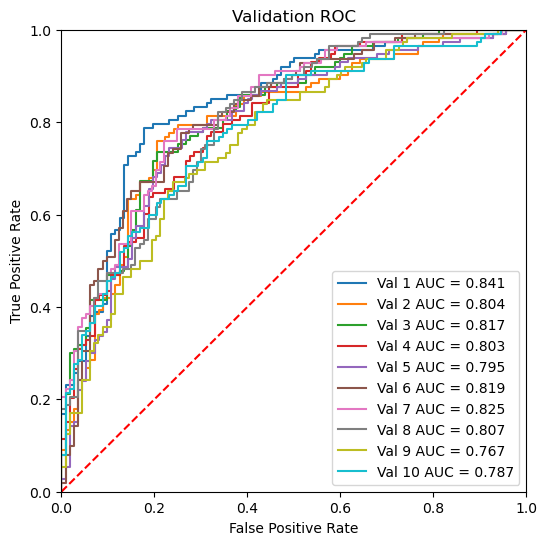

In [16]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

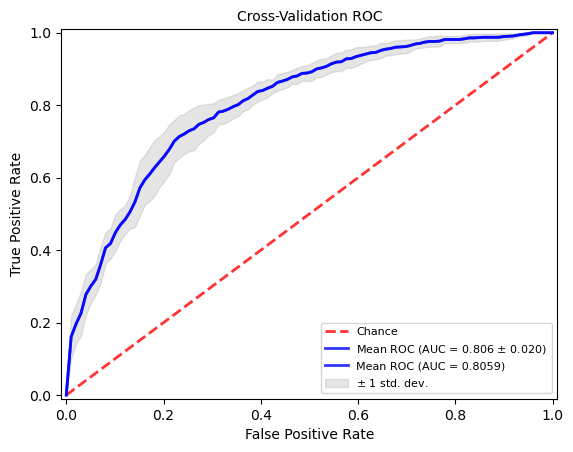

In [17]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [18]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [19]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [20]:
my_calculate_metrics_list_val

[{'SN': 0.9380530973451328,
  'SP': 0.49107142857142855,
  'ACC': 0.7155555555555555,
  'MCC': 0.48022185694455777,
  'Recall': 0.9380530973451328,
  'Precision': 0.6503067484662577,
  'F1-score': 0.7681159420289855,
  'Cutoff': 0.5},
 {'SN': 0.7857142857142857,
  'SP': 0.75,
  'ACC': 0.7678571428571429,
  'MCC': 0.5360562674188974,
  'Recall': 0.7857142857142857,
  'Precision': 0.7586206896551724,
  'F1-score': 0.7719298245614035,
  'Cutoff': 0.5},
 {'SN': 0.8761061946902655,
  'SP': 0.5625,
  'ACC': 0.72,
  'MCC': 0.46221791476594426,
  'Recall': 0.8761061946902655,
  'Precision': 0.668918918918919,
  'F1-score': 0.7586206896551724,
  'Cutoff': 0.5},
 {'SN': 0.7079646017699115,
  'SP': 0.7321428571428571,
  'ACC': 0.72,
  'MCC': 0.4402118198498351,
  'Recall': 0.7079646017699115,
  'Precision': 0.7272727272727273,
  'F1-score': 0.7174887892376681,
  'Cutoff': 0.5},
 {'SN': 0.8230088495575221,
  'SP': 0.625,
  'ACC': 0.7244444444444444,
  'MCC': 0.4572426013181372,
  'Recall': 0.82300

In [21]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.938053,0.491071,0.715556,0.480222,0.938053,0.650307,0.768116,0.5
1,0.785714,0.750000,0.767857,0.536056,0.785714,0.758621,0.771930,0.5
2,0.876106,0.562500,0.720000,0.462218,0.876106,0.668919,0.758621,0.5
3,0.707965,0.732143,0.720000,0.440212,0.707965,0.727273,0.717489,0.5
4,0.823009,0.625000,0.724444,0.457243,0.823009,0.688889,0.750000,0.5
5,0.830357,0.628319,0.728889,0.468129,0.830357,0.688889,0.753036,0.5
6,0.758929,0.778761,0.768889,0.537817,0.758929,0.772727,0.765766,0.5
7,0.892857,0.522124,0.706667,0.446465,0.892857,0.649351,0.751880,0.5
8,0.866071,0.477876,0.671111,0.372953,0.866071,0.621795,0.723881,0.5
9,0.901786,0.508929,0.705357,0.446623,0.901786,0.647436,0.753731,0.5


In [22]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.938053,0.491071,0.715556,0.480222,0.938053,0.650307,0.768116,0.5
1,0.785714,0.750000,0.767857,0.536056,0.785714,0.758621,0.771930,0.5
2,0.876106,0.562500,0.720000,0.462218,0.876106,0.668919,0.758621,0.5
3,0.707965,0.732143,0.720000,0.440212,0.707965,0.727273,0.717489,0.5
4,0.823009,0.625000,0.724444,0.457243,0.823009,0.688889,0.750000,0.5
5,0.830357,0.628319,0.728889,0.468129,0.830357,0.688889,0.753036,0.5
6,0.758929,0.778761,0.768889,0.537817,0.758929,0.772727,0.765766,0.5
7,0.892857,0.522124,0.706667,0.446465,0.892857,0.649351,0.751880,0.5
8,0.866071,0.477876,0.671111,0.372953,0.866071,0.621795,0.723881,0.5
9,0.901786,0.508929,0.705357,0.446623,0.901786,0.647436,0.753731,0.5


In [23]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [24]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [25]:
roc_auc_list_indep

[0.8012595663265306,
 0.8184789540816326,
 0.7829241071428571,
 0.8070790816326531,
 0.7948820153061225,
 0.8006218112244898,
 0.8065210459183674,
 0.8097895408163266,
 0.8089923469387756,
 0.8223054846938775]

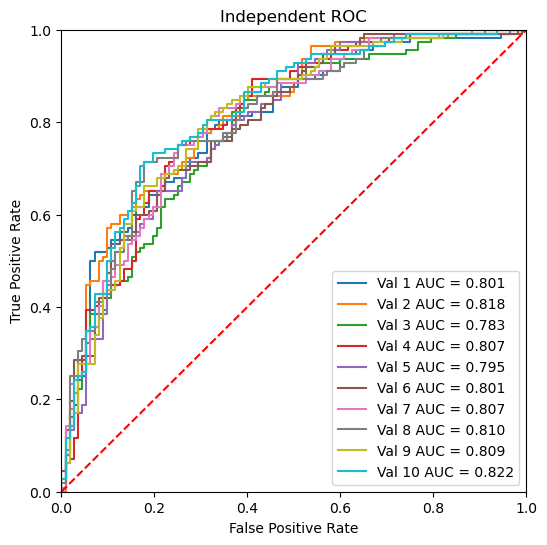

In [26]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

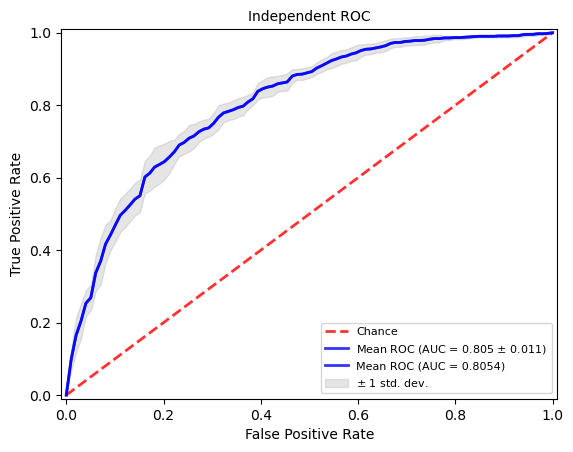

In [27]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [28]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [29]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [30]:
my_calculate_metrics_list_indep

[{'SN': 0.9017857142857143,
  'SP': 0.4375,
  'ACC': 0.6696428571428571,
  'MCC': 0.3830769733091181,
  'Recall': 0.9017857142857143,
  'Precision': 0.6158536585365854,
  'F1-score': 0.7318840579710145,
  'Cutoff': 0.5},
 {'SN': 0.7767857142857143,
  'SP': 0.6785714285714286,
  'ACC': 0.7276785714285714,
  'MCC': 0.45756935808634613,
  'Recall': 0.7767857142857143,
  'Precision': 0.7073170731707317,
  'F1-score': 0.7404255319148936,
  'Cutoff': 0.5},
 {'SN': 0.8571428571428571,
  'SP': 0.5803571428571429,
  'ACC': 0.71875,
  'MCC': 0.45528731655941607,
  'Recall': 0.8571428571428571,
  'Precision': 0.6713286713286714,
  'F1-score': 0.7529411764705882,
  'Cutoff': 0.5},
 {'SN': 0.7142857142857143,
  'SP': 0.7589285714285714,
  'ACC': 0.7366071428571429,
  'MCC': 0.4736865461516848,
  'Recall': 0.7142857142857143,
  'Precision': 0.7476635514018691,
  'F1-score': 0.730593607305936,
  'Cutoff': 0.5},
 {'SN': 0.7232142857142857,
  'SP': 0.6875,
  'ACC': 0.7053571428571429,
  'MCC': 0.410976

In [31]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.901786,0.437500,0.669643,0.383077,0.901786,0.615854,0.731884,0.5
1,0.776786,0.678571,0.727679,0.457569,0.776786,0.707317,0.740426,0.5
2,0.857143,0.580357,0.718750,0.455287,0.857143,0.671329,0.752941,0.5
3,0.714286,0.758929,0.736607,0.473687,0.714286,0.747664,0.730594,0.5
4,0.723214,0.687500,0.705357,0.410976,0.723214,0.698276,0.710526,0.5
5,0.714286,0.678571,0.696429,0.393108,0.714286,0.689655,0.701754,0.5
6,0.732143,0.758929,0.745536,0.491248,0.732143,0.752294,0.742081,0.5
7,0.875000,0.535714,0.705357,0.436613,0.875000,0.653333,0.748092,0.5
8,0.928571,0.446429,0.687500,0.428037,0.928571,0.626506,0.748201,0.5
9,0.875000,0.571429,0.723214,0.468540,0.875000,0.671233,0.759690,0.5


In [32]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.901786,0.437500,0.669643,0.383077,0.901786,0.615854,0.731884,0.5
1,0.776786,0.678571,0.727679,0.457569,0.776786,0.707317,0.740426,0.5
2,0.857143,0.580357,0.718750,0.455287,0.857143,0.671329,0.752941,0.5
3,0.714286,0.758929,0.736607,0.473687,0.714286,0.747664,0.730594,0.5
4,0.723214,0.687500,0.705357,0.410976,0.723214,0.698276,0.710526,0.5
5,0.714286,0.678571,0.696429,0.393108,0.714286,0.689655,0.701754,0.5
6,0.732143,0.758929,0.745536,0.491248,0.732143,0.752294,0.742081,0.5
7,0.875000,0.535714,0.705357,0.436613,0.875000,0.653333,0.748092,0.5
8,0.928571,0.446429,0.687500,0.428037,0.928571,0.626506,0.748201,0.5
9,0.875000,0.571429,0.723214,0.468540,0.875000,0.671233,0.759690,0.5


In [33]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_2\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

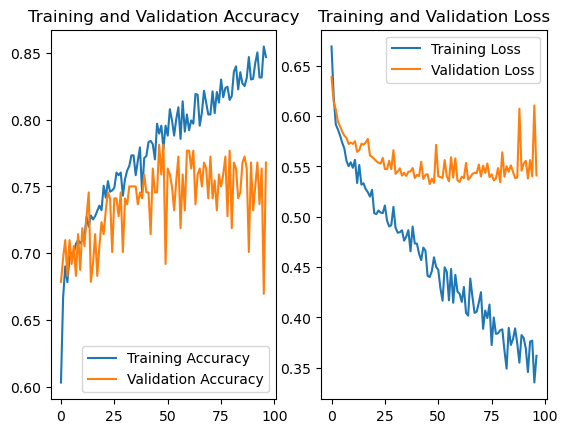

In [35]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()